## Homework 1: camera calibration

**Due date:** October 1st 2019

The goal of the assignment is to implement the linear calibration method described in Section 1.3.1 of this [book chapter](https://www.di.ens.fr/%7Eponce/introvis/sbook.pdf).

![calibration-image](img/calibration.jpg)

**Detailed instructions:** The `pts2d` array contains in its columns the (u,v) positions of the image data points (with, by convention, the u and v coordinates with origin at the bottom left of the image, u going right and v going up), while the `pts3d` array contains in its columns the (x,y,z) coordinate vectors of the corresponding 3D points in a right-handed coordinate system. The origin of the world coordinate system is supposed to be in front of the camera, with negative z value.

You should write functions that:
* Compute the 3x4 projection matrix  M estimated from these data using the linear least-squares method of Sec. 1.3.1.
* Compute the corresponding matrix K of intrinsic parameters using the method from M using the method described in the same section.
* Draw together the input image points and the projection of the 3D data points obtained using M to generate a figure like Fig. 1.18, and estimate the root-mean-sqared reprojection error.

You should also write short explanations describing your work and reporting your results.

In [1]:
import numpy as np
import math

pts2d = np.loadtxt("pts2d.txt")
pts3d = np.loadtxt("pts3d.txt")

count how many fiducial points there are

In [2]:
assert pts3d.shape[0] == pts2d.shape[0]

n = pts2d.shape[0]
print(n)

491


pad $1$ to convert to homogenuous cordinate system 

In [3]:
pts3d = np.hstack((pts3d, np.ones(n).reshape(n, -1)))
print(pts3d.shape)

(491, 4)


forming P matrix that is of shape $(2*n, 12)$

In [4]:
import math

P = np.zeros((2*n, 12)) # memory allocation

for i in range(2*n):
    n_index = math.floor(i / 2) # index of the fiducial point that we are on in [0, n]
    P_i = pts3d[n_index]
    
    if i % 2 == 0:
        x_i = pts2d[n_index, 0]
        P[i, :4] = P_i
        P[i, -4:] = -x_i*P_i
    else:
        y_i = pts2d[n_index, 1]
        P[i, 4:8] = P_i
        P[i, -4:] = -y_i*P_i

In [5]:
P.shape

(982, 12)

compute eigenvalues for $P^T*P$ using SVD

In [6]:
u, s, vh = np.linalg.svd(P, full_matrices=True)

In [7]:
print(u.shape, s.shape, vh.shape)

(982, 982) (12,) (12, 12)


In [8]:
s

array([2.13102637e+06, 9.52434729e+05, 6.33491338e+05, 4.49948325e+03,
       3.53812573e+03, 2.56383354e+03, 1.62349965e+03, 7.57454031e+02,
       7.01455640e+02, 3.28737627e+02, 6.73260330e+00, 4.31611461e-02])

set m to be the eigenvector associated with the smallest eigenvalue

In [9]:
m = vh[-1]

make sure that $m$ is an unit vector

In [10]:
np.linalg.norm(m)

1.0000000000000002

**reshape the $m$ vector to get projection matrix $M$**

In [11]:
M = m.reshape(3, 4)

In [12]:
M

array([[-4.53359881e-03, -5.65451256e-04,  2.02849590e-03,
        -5.23179344e-01],
       [-1.84278426e-03,  4.15975903e-03, -1.68779276e-03,
        -8.52192928e-01],
       [-3.25683227e-06, -1.13804182e-06, -3.35237791e-06,
        -1.43209220e-03]])

In [13]:
A = M[:, :3]
b = M[:, -1]

Equation 1.24

In [14]:
rho = 1/np.linalg.norm(A[-1])
r_3 = rho*A[-1]
x_0 = (rho**2)*(np.dot(A[0], A[-1]))
y_0 = (rho**2)*(np.dot(A[1], A[-1]))

Equation 1.26

In [15]:
cos_theta = -np.dot(np.cross(A[0], A[-1]), np.cross(A[1], A[-1]))/(np.linalg.norm(np.cross(A[0], A[-1])) * np.linalg.norm(np.cross(A[1], A[-1])))
theta = math.acos(cos_theta)
sin_theta = np.sin(theta)
alpha = (rho**2) * np.linalg.norm(np.cross(A[0], A[-1])) * sin_theta
beta = (rho**2) * np.linalg.norm(np.cross(A[1], A[-1])) * sin_theta

In [16]:
print("theta: {}, alpha: {}, beta: {}, x_0: {}, y_0: {}".format(theta, alpha, beta, x_0, y_0))

theta: 1.5708979824246432, alpha: 970.284101291283, beta: 963.346576327692, x_0: 372.00496376318, y_0: 299.2920935163564


In [17]:
K = np.array([[alpha, -alpha*cos_theta/sin_theta, x_0], [0, beta/sin_theta, y_0], [0, 0, 1]])

**printing out the intrinsic matrix $K$**

In [18]:
K

array([[9.70284101e+02, 9.86348417e-02, 3.72004964e+02],
       [0.00000000e+00, 9.63346581e+02, 2.99292094e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

Equation 1.27

In [19]:
r_1 = np.cross(A[1], A[-1])/np.linalg.norm(np.cross(A[1], A[-1]))
r_2 = np.cross(r_3, r_1)

In [20]:
R = np.array([r_1, r_2, r_3]).T

In [21]:
R

array([[-0.71171772, -0.18731413, -0.67703124],
       [-0.03054192,  0.97113272, -0.23657647],
       [ 0.70180131, -0.14769783, -0.6968933 ]])

In [22]:
r_2

array([-0.18731413,  0.97113272, -0.14769783])

$t = \rho K^{-1}b$

In [23]:
t = rho*np.dot(np.linalg.inv(K), b)

$\rho M = K[A| b] = \text{transform}$

In [24]:
transform = np.matmul(K, np.hstack((R, t.reshape(3, 1))))

In [25]:
transform

array([[-4.29497826e+02, -2.36596465e+02, -9.16183753e+02,
        -1.08758675e+05],
       [ 1.80621129e+02,  8.91332597e+02, -4.36479785e+02,
        -1.77154115e+05],
       [ 7.01801312e-01, -1.47697829e-01, -6.96893298e-01,
        -2.97703746e+02]])

Plots

In [26]:
import matplotlib.pyplot as plt

$p = MP$, where projection $p$ is in homogenuous cordinate system

In [27]:
projection_homogenuous = np.dot(M, pts3d.T).T 

In [28]:
projection_homogenuous

array([[-0.5996651 , -0.81743831, -0.00149802],
       [-0.66766908, -0.84508007, -0.00154687],
       [-0.73567306, -0.87272183, -0.00159572],
       ...,
       [-0.15538068, -0.38391235, -0.00247588],
       [-0.16386245, -0.32151596, -0.00249295],
       [-0.17234421, -0.25911958, -0.00251002]])

convert homogenuous cordinate system back to euclidean cordinate system by dividing every 1st and 2nd entry by the third entry

$[u, v, w] \to [\frac{u}{w}, \frac{v}{w}, 1] $

In [29]:
projection_euclidean = projection_homogenuous / projection_homogenuous[:, -1].reshape(-1, 1)

In [30]:
projection_euclidean

array([[400.30638484, 545.68087381,   1.        ],
       [431.62646329, 546.31693182,   1.        ],
       [461.02883267, 546.91404438,   1.        ],
       ...,
       [ 62.75783109, 155.06114905,   1.        ],
       [ 65.73039775, 128.97019819,   1.        ],
       [ 68.66253157, 103.23413628,   1.        ]])

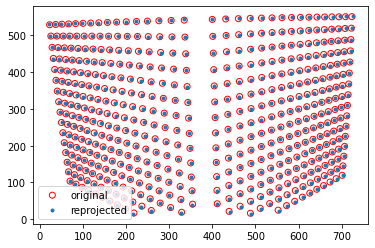

In [31]:
plt.scatter(pts2d[:, 0], pts2d[:, 1], label="original", edgecolors='red', facecolors='none')
plt.scatter(projection_euclidean[:, 0], projection_euclidean[:, 1], label="reprojected", marker=".")
plt.legend()

In [32]:
print("root-mean-sqared reprojection error:", np.sqrt(np.mean(np.linalg.norm(pts2d-projection_euclidean[:, :2], axis=1)**2)))

root-mean-sqared reprojection error: 0.9573541630285444
